# Лабораторная работа 3 — Кластеризация стран по социально-экономическим показателям

ЗАГРУЗКА И ПЕРВИЧНАЯ ПОДГОТОВКА

In [23]:


import pandas as pd
import numpy as np

df = pd.read_csv("../Lab3.csv")

df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
)

assert 'country' in df.columns, "В таблице должен быть столбец country"

id_col = 'country'
features = [c for c in df.columns if c != id_col]

print(df.shape)
print(df.dtypes)
print(df.head())


(167, 10)
country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


Проверяем пропуски и дубликаты

In [24]:
print("Пропуски по столбцам:")
print(df.isna().sum().sort_values(ascending=False))

print("\nКоличество дубликатов по стрнам:", df['country'].duplicated().sum())

Пропуски по столбцам:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Количество дубликатов по стрнам: 0


Описательная статистика

In [25]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


Корреляции между признаками

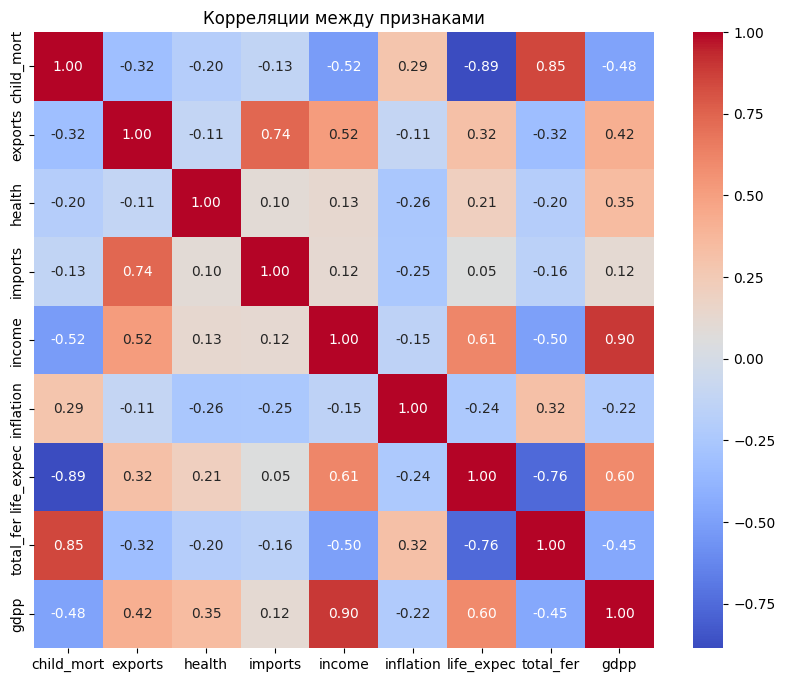

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляции между признаками")
plt.show()

Визуализация распределений

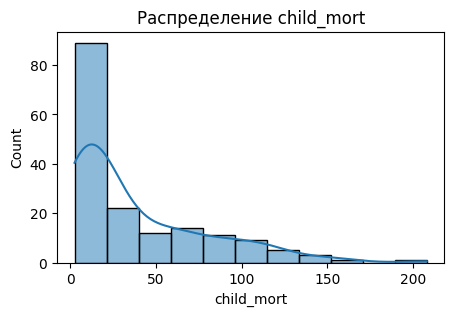

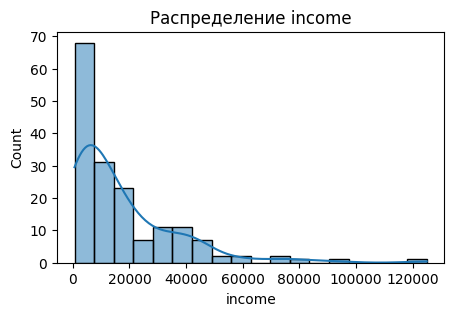

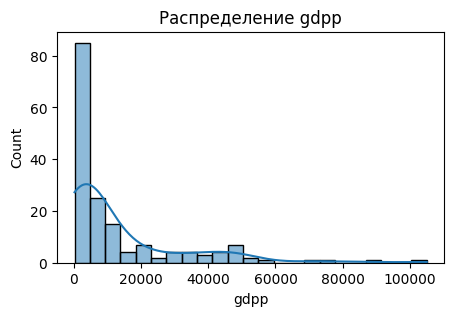

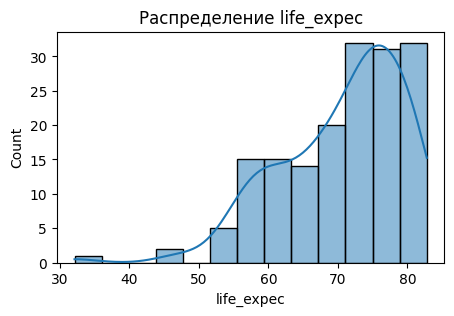

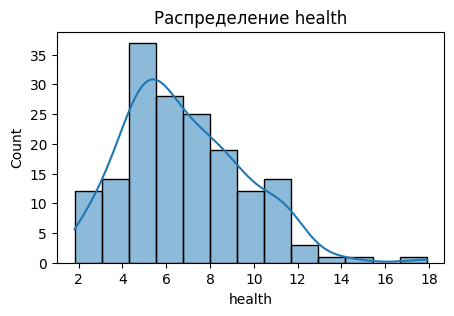

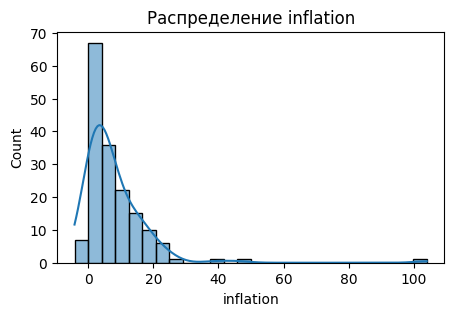

In [27]:
key_cols = ['child_mort', 'income', 'gdpp', 'life_expec', 'health', 'inflation']

for col in key_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Распределение {col}")
    plt.show()


ПРЕДОБРАБОТКА ДАННЫХ

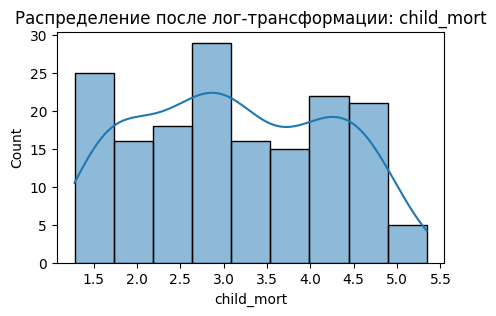

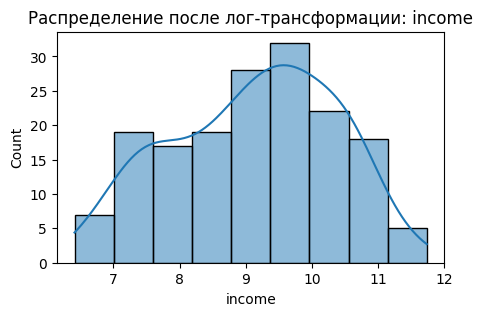

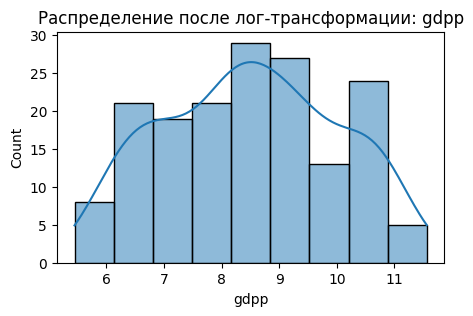

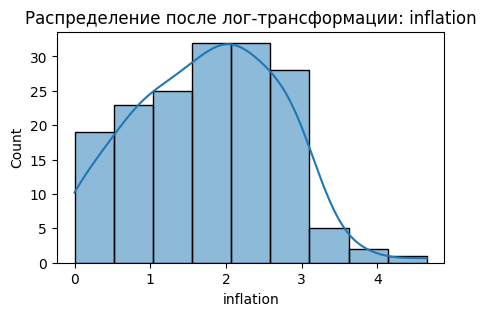

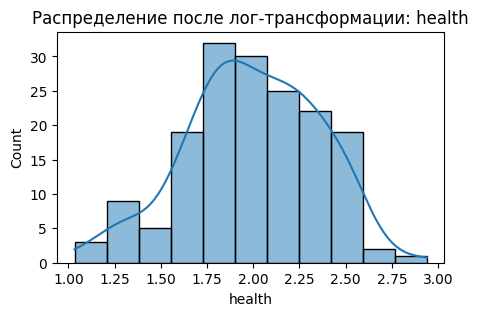

In [28]:
# --- ЭТАП 4. ПРЕДОБРАБОТКА И ЛОГ-ТРАНСФОРМАЦИЯ ДАННЫХ ---

from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

work = df.copy()

imp = SimpleImputer(strategy='median')
work[features] = imp.fit_transform(work[features])

skewed_cols = ['child_mort', 'income', 'gdpp', 'inflation', 'health']

for col in skewed_cols:
    work[col] = np.log1p(work[col].clip(lower=0))

for col in skewed_cols:
    plt.figure(figsize=(5, 3))
    sns.histplot(work[col], kde=True)
    plt.title(f"Распределение после лог-трансформации: {col}")
    plt.show()


 МАСШТАБИРОВАНИЕ И PCA


PCA объясняет 72.97% общей дисперсии


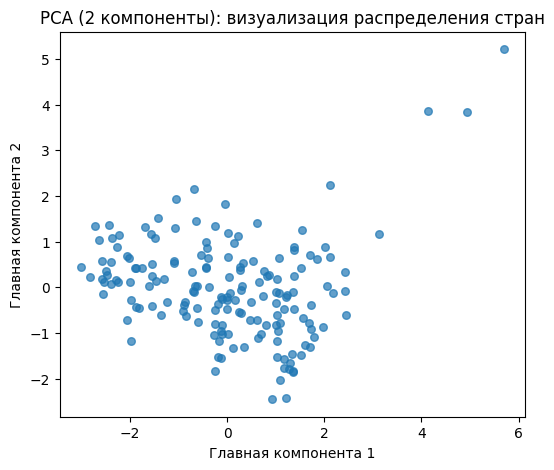

In [29]:


from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaled_features = [c for c in work.columns if c != 'country']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(work[scaled_features])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_.sum()
print(f"PCA объясняет {explained:.2%} общей дисперсии")

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=30, alpha=0.7)
plt.title("PCA (2 компоненты): визуализация распределения стран")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()


КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-MEANS

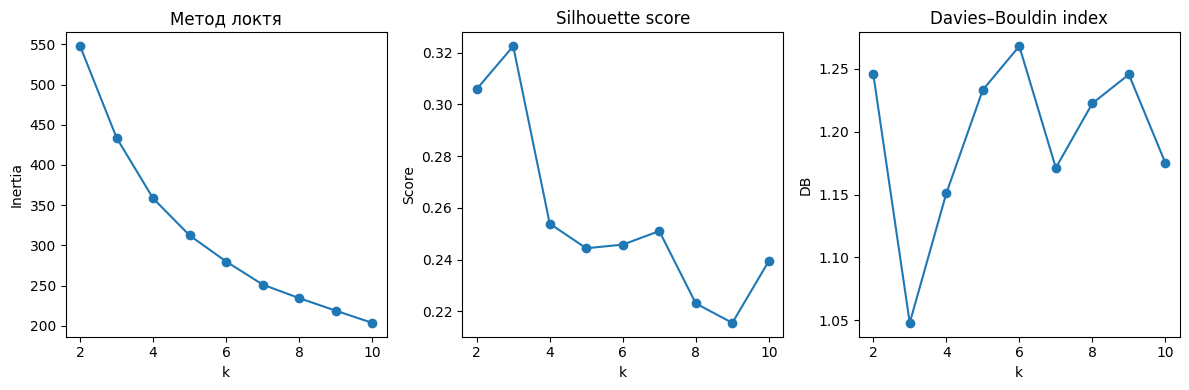

Оптимальное количество кластеров: 3


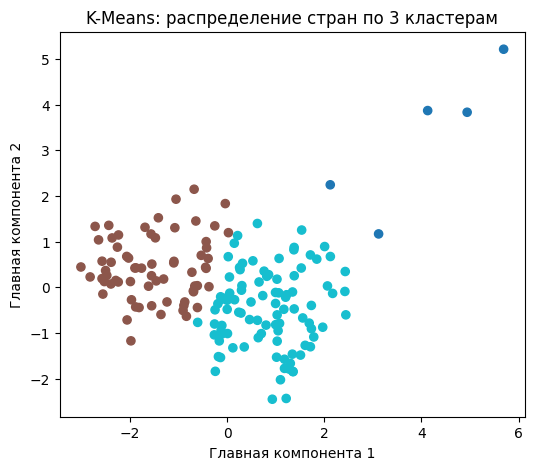

In [30]:
# --- ЭТАП 6. КЛАСТЕРИЗАЦИЯ МЕТОДОМ K-MEANS ---

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

ks = range(2, 11)
inertia, sil, db = [], [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, labels))
    db.append(davies_bouldin_score(X_scaled, labels))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(ks, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(ks, sil, marker='o')
plt.title('Silhouette score')
plt.xlabel('k'); plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(ks, db, marker='o')
plt.title('Davies–Bouldin index')
plt.xlabel('k'); plt.ylabel('DB')

plt.tight_layout()
plt.show()

best_k = ks[np.argmax(sil)]
print(f"Оптимальное количество кластеров: {best_k}")

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=35)
plt.title(f"K-Means: распределение стран по {best_k} кластерам")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()


АНАЛИЗ И ПРОФИЛИРОВАНИЕ КЛАСТЕРОВ

In [31]:


from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np

res = work.copy()
res['cluster_km'] = labels

cluster_profile = res.groupby('cluster_km')[scaled_features].median().sort_index()
print("Медианные значения признаков по кластерам:")
print(cluster_profile, "\n")

centers = kmeans.cluster_centers_
dists = pairwise_distances(X_scaled, centers)
medoid_idx = dists.argmin(axis=0)
medoid_countries = df.iloc[medoid_idx]['country'].tolist()

print("Эталонные страны по кластерам:")
for i, name in enumerate(medoid_countries):
    print(f"Кластер {i}: {name}")

cluster_profile


Медианные значения признаков по кластерам:
            child_mort  exports    health  imports     income  inflation  \
cluster_km                                                                 
0             1.648659    153.0  2.171337    142.0  10.729875   0.000000   
1             4.216562     24.9  1.853168     40.3   7.832411   2.280339   
2             2.442347     39.7  2.083185     43.7   9.814711   1.510722   

            life_expec  total_fer       gdpp  
cluster_km                                    
0                 80.4       1.63  10.749377  
1                 61.8       4.60   7.039660  
2                 76.3       1.92   9.323758   

Эталонные страны по кластерам:
Кластер 0: Malta
Кластер 1: Ghana
Кластер 2: Poland


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_km,,,,,,,,,
0,1.648659,153.0,2.171337,142.0,10.729875,0.000000,80.4,1.63,10.749377
1,4.216562,24.9,1.853168,40.3,7.832411,2.280339,61.8,4.60,7.039660
2,2.442347,39.7,2.083185,43.7,9.814711,1.510722,76.3,1.92,9.323758


ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ (WARD)

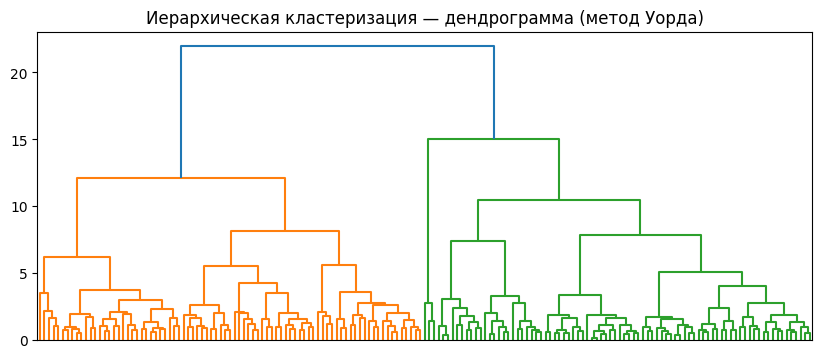

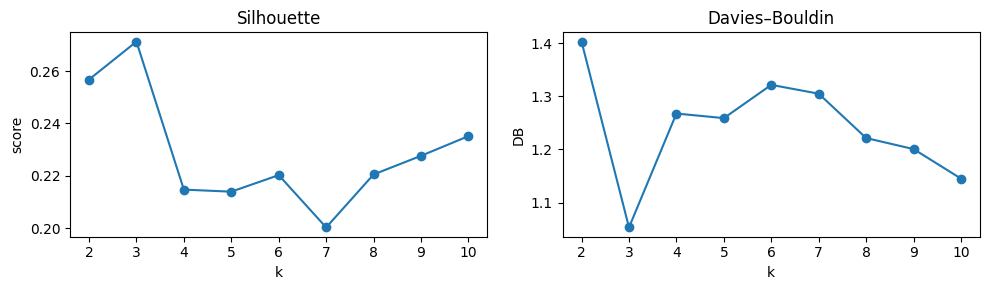

Оптимальное число кластеров: 3 (silhouette = 0.271)


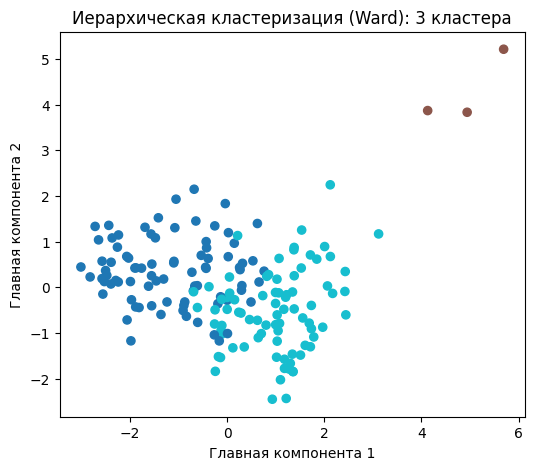

In [32]:


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True, color_threshold=None, distance_sort='ascending')
plt.title("Иерархическая кластеризация — дендрограмма (метод Уорда)")
plt.show()

ks = range(2, 11)
sil, db = [], []
best_k_h, best_sil = None, -1
best_labels_h = None

for k in ks:
    labels_h = fcluster(Z, k, criterion='maxclust')
    s = silhouette_score(X_scaled, labels_h)
    d = davies_bouldin_score(X_scaled, labels_h)
    sil.append(s)
    db.append(d)
    if s > best_sil:
        best_sil, best_k_h, best_labels_h = s, k, labels_h

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(ks, sil, marker='o')
plt.title('Silhouette')
plt.xlabel('k'); plt.ylabel('score')

plt.subplot(1, 2, 2)
plt.plot(ks, db, marker='o')
plt.title('Davies–Bouldin')
plt.xlabel('k'); plt.ylabel('DB')
plt.tight_layout()
plt.show()

print(f"Оптимальное число кластеров: {best_k_h} (silhouette = {best_sil:.3f})")

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels_h, cmap='tab10', s=35)
plt.title(f"Иерархическая кластеризация (Ward): {best_k_h} кластера")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()

labels_h = best_labels_h


КЛАСТЕРИЗАЦИЯ МЕТОДОМ DBSCAN

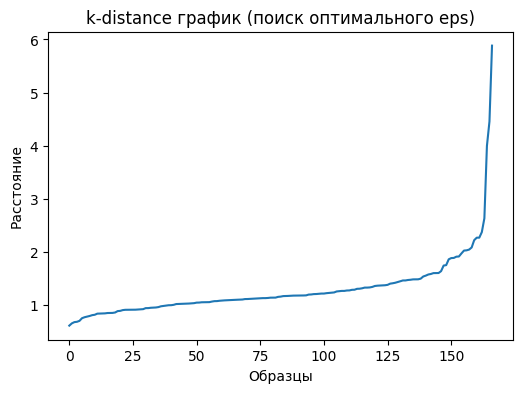

Количество кластеров: 1
Доля шума: 7.78%
Silhouette-score не рассчитывается (один кластер или меньше)


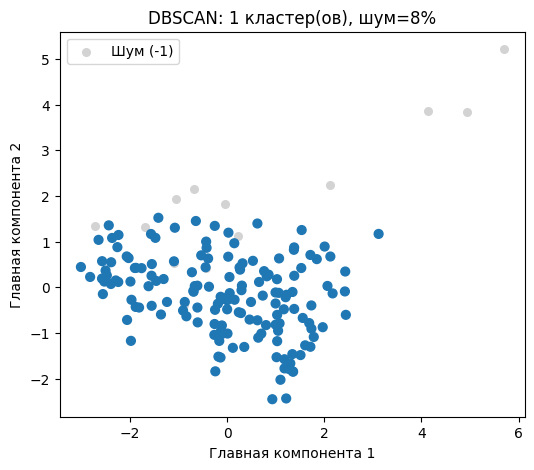

In [33]:


from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

min_samples = 8

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.title("k-distance график (поиск оптимального eps)")
plt.xlabel("Образцы")
plt.ylabel("Расстояние")
plt.show()

eps = 1.5  # значение выбирается по графику излома

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = dbscan.fit_predict(X_scaled)

n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
noise_share = np.mean(labels_db == -1)

print(f"Количество кластеров: {n_clusters}")
print(f"Доля шума: {noise_share:.2%}")

if n_clusters >= 2:
    sil = silhouette_score(X_scaled, labels_db)
    print(f"Silhouette-score: {sil:.3f}")
else:
    print("Silhouette-score не рассчитывается (один кластер или меньше)")

plt.figure(figsize=(6, 5))
mask_noise = labels_db == -1
plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1], c="lightgray", s=30, label="Шум (-1)")
plt.scatter(X_pca[~mask_noise, 0], X_pca[~mask_noise, 1], c=labels_db[~mask_noise], cmap="tab10", s=40)
plt.title(f"DBSCAN: {n_clusters} кластер(ов), шум={noise_share:.0%}")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend()
plt.show()
